In [1]:
import os
import sys
import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from torchvision import transforms
# from PIL import Image
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader
sys.path.append(os.path.abspath(os.path.join('..', '..', 'models', 'AutoEncoders')))
# from cnn_autoencoder import CNNAutoencoder

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
base_path = '../../data/interim/4/fashion_mnist'
train_path = f'{base_path}/fashion-mnist_train.csv'
val_path = f'{base_path}/fashion-mnist_val.csv'
test_path = f'{base_path}/fashion-mnist_test.csv'

train_df = pd.read_csv(train_path)

Load the Fashion MNIST dataset from kaggle. Split the training data into
train, val and test

In [ ]:
# base_path = '../../data/external/fashion_mnist'
# train_path = f'{base_path}/fashion-mnist_train.csv'
# test_path = f'{base_path}/fashion-mnist_test.csv'
# output_path = '../../data/interim/4/fashion_mnist'

# train_df = pd.read_csv(train_path)
# test_df = pd.read_csv(test_path)

# train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# train_df_split = train_df[:50000]
# val_df_split = train_df[50000:]

# train_df_split.to_csv(f'{output_path}/fashion-mnist_train.csv', index=False)
# val_df_split.to_csv(f'{output_path}/fashion-mnist_val.csv', index=False)
# test_df.to_csv(f'{output_path}/fashion-mnist_test.csv', index=False)

# print("Data shuffled, split, and saved successfully.")


In [ ]:
num_labels = 10 
fig, axes = plt.subplots(num_labels, 5, figsize=(10, num_labels * 2.5))

for label in range(num_labels):
    images = train_df[train_df.iloc[:, 0] == label].iloc[:, 1:].values[:5] 
    for j, image in enumerate(images):
        image_reshaped = image.reshape(28, 28)
        axes[label, j].imshow(image_reshaped, cmap='gray')
        axes[label, j].set_title(f'Label: {label}')
        axes[label, j].axis('off')
plt.tight_layout()
plt.show()

Try to list the clothing type represented by each class (don’t google this,
try it out yourself)

0. **T-shirt**

1. **Trousers**

2. **Sweatesr**: This looks like warm clothing, mostly without a zipper.

3. **Dress**

4. **Jackets**: This looks like warm clothing, with what seems like zippers in most cases.

5. **Sandals**: The images shows open footwear, like heels and wedges.

6. **Shirts/Polos**: This looks like a collared shirt with buttons down the front.

7. **Sneakers**: These appear to be athletic shoes.

8. **Bag**: These resemble purses or handbags.

9. **Boots**: These look like footwear but are higher than the sneakers.

Implement the CnnAutoencoder class

In [3]:
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

def load_fashion_data():
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)

    # Extract features and labels as numpy arrays
    X_train = train_df.iloc[:, 1:].values.astype('float32') / 255.0  # Scale to [0, 1]
    y_train = train_df.iloc[:, 0].values  # Labels
    
    X_val = val_df.iloc[:, 1:].values.astype('float32') / 255.0  # Scale to [0, 1]
    y_val = val_df.iloc[:, 0].values  # Labels
    
    X_test = test_df.iloc[:, 1:].values.astype('float32') / 255.0  # Scale to [0, 1]
    y_test = test_df.iloc[:, 0].values  # Labels (if available)
    
    return (train_df, val_df, test_df), (X_train, y_train, X_val, y_val, X_test, y_test)

class MultiMNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = self.dataframe.iloc[idx, 0]
        image = self.dataframe.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)  # Convert to 2D array
        image = Image.fromarray(image)  # Convert to PIL Image

        if self.transform:
            image = self.transform(image)
        
        return image, label

(dataframes, (X_train, y_train, X_val, y_val, X_test, y_test)) = load_fashion_data()

transform = transforms.Compose([
    transforms.ToTensor(), 
])

batch_size = 64
train_dataset = MultiMNISTDataset(dataframes[0], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MultiMNISTDataset(dataframes[1], transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = MultiMNISTDataset(dataframes[2], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
sample=test_dataset[0]
image, label = sample
print(image[0][10][10])
print(X_test[0][28*10+10])

In [ ]:
model = CNNAutoencoder(device=device).to(device)
model.fit(train_loader, num_epochs=10, learning_rate=0.001)
model.evaluate(test_loader)

In [ ]:
import matplotlib.pyplot as plt

def show_reconstructed_images(model, data_loader, num_images=10):
    model.eval()
    
    data_iter = iter(data_loader)
    images, _ = next(data_iter)
    images = images[:num_images]  
    images = images.to(device)
    
    with torch.no_grad():
        reconstructed = model(images)

    images = images.cpu()
    reconstructed = reconstructed.cpu()
    
    fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
    for i in range(num_images):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    
    plt.show()

show_reconstructed_images(model, test_loader, num_images=10)


In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def plot_latent_space(model, data_loader, num_samples=1000):
    model.eval()
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            encoded = model.encode(x)
            latent_representations.append(encoded.view(encoded.size(0), -1).cpu().numpy())
            labels.extend(y.cpu().numpy())
            if len(labels) >= num_samples:
                break
    
    latent_representations = np.concatenate(latent_representations)[:num_samples]
    labels = np.array(labels)[:num_samples]
    
    pca_2d = PCA(n_components=2)
    latent_2d = pca_2d.fit_transform(latent_representations)
    
    pca_3d = PCA(n_components=3)
    latent_3d = pca_3d.fit_transform(latent_representations)

    # 2D plot
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Class Label')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("2D PCA of Latent Space")
    plt.show()

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=labels, cmap='tab10', alpha=0.7)
    fig.colorbar(scatter, ax=ax, label='Class Label')
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    plt.title("3D PCA of Latent Space")
    plt.show()

plot_latent_space(model, test_loader)


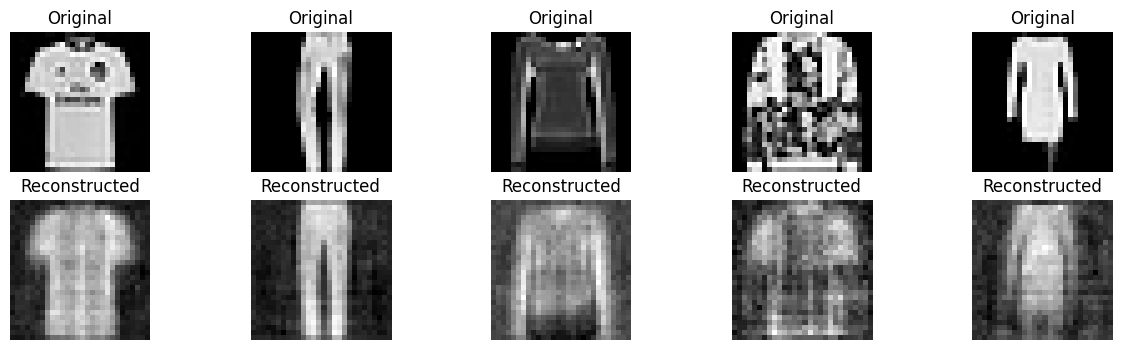

In [17]:
# from AutoEncoders import AutoEncoder


# input_size = 28*28
# latent_size = 75
# encoder_layers = []  
# decoder_layers = []  
# learning_rate = 0.08
# max_epochs = 50
# batch_size = 32

# autoencoder = AutoEncoder(
#     input_size=input_size,
#     latent_size=latent_size,
#     encoder_layers=encoder_layers,
#     decoder_layers=decoder_layers,
#     learning_rate=learning_rate,
#     optimizer='mbgd'
# )
# print(X_train.shape)
# autoencoder.fit(X_train, max_epochs=max_epochs, batch_size=batch_size)
# X_reconstructed = autoencoder.reconstruct(X_train)

import matplotlib.pyplot as plt
def visualize_reconstruction(autoencoder, X_test, n_images=5):
    X_reconstructed = autoencoder.reconstruct(X_test[:n_images])

    fig, axes = plt.subplots(2, n_images, figsize=(15, 4))
    for i in range(n_images):
        axes[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

visualize_reconstruction(mlp_autoencoder_knn, X_test)

In [ ]:
print(X_train[0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pca_autoencoder import PcaAutoencoder

def plot_construction_loss(X_train, max_components=20):
    errors = []
    for n in range(1, max_components + 1):
        pca_autoencoder = PcaAutoencoder(n_components=n)
        pca_autoencoder.fit(X_train)
        error = pca_autoencoder.reconstruction_error(X_train)
        errors.append(error)

    plt.plot(range(1, max_components + 1), errors, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error')
    plt.title('Reconstruction Error vs Number of Components')
    plt.grid(True)
    plt.show()
    return errors

errors = plot_construction_loss(X_train)


In [ ]:

pca_autoencoder = PcaAutoencoder(n_components=75)
pca_autoencoder.fit(X_train)

def visualize_reconstruction(autoencoder, X_test, n_images=5):
    X_reconstructed = autoencoder.forward(X_test[:n_images])

    fig, axes = plt.subplots(2, n_images, figsize=(15, 4))
    for i in range(n_images):
        axes[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

visualize_reconstruction(pca_autoencoder, X_val)

#### KNN Classification

In [4]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'models', 'knn')))
sys.path.append(os.path.abspath(os.path.join('..', '..', 'performance_measures')))
from knn import KNN
from classification_metrics import Metrics

In [5]:
from pca_autoencoder import PcaAutoencoder
pca_autoencoder_knn = PcaAutoencoder(n_components=64)
pca_autoencoder_knn.fit(X_train)

X_train_encoded_pca = pca_autoencoder_knn.encode(X_train)
X_test_encoded_pca = pca_autoencoder_knn.encode(X_test)

In [6]:
knn_pca = KNN(k=5, distance_metric='cosine')
knn_pca.fit(X_train_encoded_pca, y_train)
y_pred_pca_1 = knn_pca.predict(X_test_encoded_pca[:5000])
y_pred_pca_2 = knn_pca.predict(X_test_encoded_pca[5000:])
scores_pca = Metrics(y_test, np.concatenate((y_pred_pca_1,y_pred_pca_2)), task='classification')
accuracy_pca = scores_pca.accuracy()
print(f"Accuracy of KNN with PCA: {accuracy_pca:.5f}")

Accuracy of KNN with PCA: 0.86310


In [ ]:
from AutoEncoders import AutoEncoder


input_size = 28*28
latent_size = 75
encoder_layers = []  
decoder_layers = []  
learning_rate = 0.01
max_epochs = 20
batch_size = 32

mlp_autoencoder_knn = AutoEncoder(
    input_size=input_size,
    latent_size=latent_size,
    encoder_layers=encoder_layers,
    decoder_layers=decoder_layers,
    learning_rate=learning_rate,
    optimizer='sgd'
)
print(X_train.shape)
mlp_autoencoder_knn.fit(X_train, max_epochs=max_epochs, batch_size=batch_size)
X_train_encoded_mlp = mlp_autoencoder_knn.get_latent(X_train)
X_test_encoded_mlp = mlp_autoencoder_knn.get_latent(X_test)

(50000, 784)
Epoch 1/20, Loss: 0.03527552569864907
Epoch 2/20, Loss: 0.020954353880839247
Epoch 3/20, Loss: 0.018760958442633813
Epoch 4/20, Loss: 0.017960207499644255


In [37]:
knn_mlp = KNN(k=5, distance_metric='cosine')
knn_mlp.fit(X_train_encoded_mlp, y_train)
y_pred_mlp_1 = knn_mlp.predict(X_test_encoded_mlp[:5000])
y_pred_mlp_2 = knn_mlp.predict(X_test_encoded_mlp[5000:])
scores_mlp = Metrics(y_test, np.concatenate((y_pred_mlp_1,y_pred_mlp_2)), task='classification')
accuracy_mlp = scores_mlp.accuracy()
print(f"Accuracy of KNN with MLP: {accuracy_mlp:.5f}")

Accuracy of KNN with MLP: 0.84620
